<a href="https://colab.research.google.com/github/kevinhhl/portfolio-management-tools/blob/main/Monte_Carlo_Simulation_Random_Walk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview:
This script will obtain historical price data from Yahoo and then perform a Monte Carlo Simulation by doing a random walk to forecast the reasonable ranges of prices.


**Parameters**

In [1]:
ticker                                              = "TSLA"
hist_yyyy, hist_mm, hist_dd                         = 2018, 1, 1                 # start date, historical lookback
t0_yyyy, t0_mm, t0_dd                               = 2023, 2, 13                # [t0] end date for historical lookback, and start date for simulations
tn_yyyy, tn_mm, tn_dd                               = 2023, 4, 21                # [tn] end date for simulations (no. of periods to be determined based on no. of business days in between t0 and tn)


Number of iterations should be at least 500, and 800, in order for forecasted mean and standard deviation values (respectively) to converge. [1]



In [2]:
n_iters                                             = 5000                       # No. of iterations for random walk. 
assert n_iters > 800

# Processing source data:

In [3]:
import datetime
import time

date_from = time.mktime(datetime.date(hist_yyyy, hist_mm, hist_dd).timetuple())
date_to = time.mktime(datetime.date(t0_yyyy, t0_mm, t0_dd).timetuple())

s1 = "https://query1.finance.yahoo.com/v7/finance/download/"
_s2 = str(int(date_from))
_s3 = str(int(date_to))
s4 = "?period1="+ _s2 +"&period2="+ _s3 +"&interval=1d&events=history&includeAdjustedClose=true"
s5 = s1 + ticker + s4

In [4]:
import pandas as pd
csv = pd.read_csv(s5)
csv

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,20.799999,21.474001,20.733334,21.368668,21.368668,65283000
1,2018-01-03,21.400000,21.683332,21.036667,21.150000,21.150000,67822500
2,2018-01-04,20.858000,21.236668,20.378668,20.974667,20.974667,149194500
3,2018-01-05,21.108000,21.149332,20.799999,21.105333,21.105333,68868000
4,2018-01-08,21.066668,22.468000,21.033333,22.427334,22.427334,147891000
...,...,...,...,...,...,...,...
1282,2023-02-06,193.009995,198.169998,189.919998,194.759995,194.759995,186188100
1283,2023-02-07,196.429993,197.500000,189.550003,196.809998,196.809998,186010300
1284,2023-02-08,196.100006,203.000000,194.309998,201.289993,201.289993,180673600
1285,2023-02-09,207.779999,214.000000,204.770004,207.320007,207.320007,215431400


**Historical Returns**

*   pc = historical log returns, based on Adjusted Close
*   drift = mean minus half-variance of historical log returns



In [5]:
import numpy as np

adj_close = csv["Adj Close"]
pc = np.log(1+adj_close.pct_change()) 

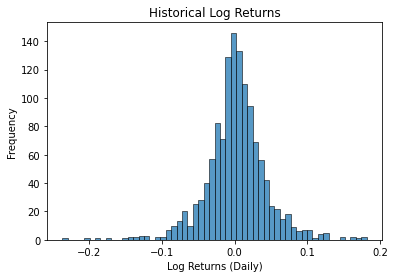

In [6]:
import matplotlib.pyplot as plt
import seaborn as sb

sb.histplot(pc.iloc[1:])
plt.title("Historical Log Returns")
plt.xlabel("Log Returns (Daily)")
plt.ylabel("Frequency");

In [7]:
mean = pc.mean()
var = pc.var()
stddev = pc.std()
drift = mean - 0.5*var
print("mean={}, var={}, drift={}".format(mean, var, drift))


mean=0.0017268425000435464, var=0.0017203510268876906, drift=0.0008666669865997011


# Performing Random Walk

In [8]:
from datetime import date
from pandas.tseries.offsets import BDay

date_t0 = date(t0_yyyy, t0_mm, t0_dd)
date_tn = date(tn_yyyy, tn_mm, tn_dd)

n_forecast = 0        # Counter++ for each business days existing in between t0 and tn
_t0 = date_t0         # tmp var.
while _t0 <= date_tn:
  n_forecast += 1
  _t0 += BDay(1)

<ipython-input-8-c6872b143809>:9: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  while _t0 <= date_tn:



TSLAShape=(50, 5000)
Simulation: From 2023-02-13 to 2023-04-21; Business days=49


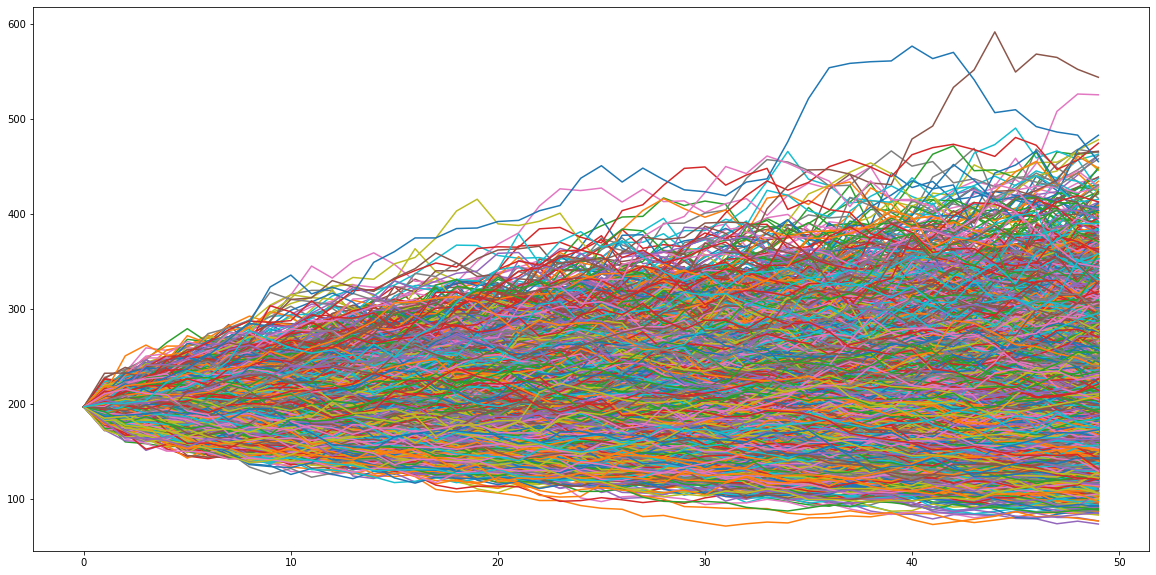

In [9]:
from scipy.stats import norm

# Init. array[n_forecast][n_iters] of zeros 
rand_returns = np.exp(drift + stddev * norm.ppf(np.random.rand(n_forecast,n_iters)))
sim_equity_curve = np.zeros_like(rand_returns)

# Assume single asset porfolio. Value of portfolio on day 1 of forecast is the Adj. Close price on that date. 
sim_equity_curve[0] = adj_close[len(adj_close)-1]

# Perform random walk and plot
for t in range(1,n_forecast):
    sim_equity_curve[t] = sim_equity_curve[t-1]*rand_returns[t]

assert(sim_equity_curve.shape==rand_returns.shape)
print("\n{}Shape={}".format(ticker, sim_equity_curve.shape))
print("Simulation: From {} to {}; Business days={}".format(date_t0, date_tn, np.busday_count(date_t0, date_tn))) 

plt.figure(figsize=(20,10))
plt.plot(pd.DataFrame(sim_equity_curve).iloc[:,0:]);

In [10]:
count = 0
stdev_multi = 2
print("{}\nt+n; \t\t\t\tstd \t\tmean \t\tmean - {}*std \t\tmean + {}*std \n"\
      .format(ticker, stdev_multi,stdev_multi))
for e in sim_equity_curve:
  std = e.std()
  mean = e.mean()
  print("t+{} \t{} \tstd = {} \tmean = {} \tlower = {} \t\tupper = {}"\
        .format(count, date_t0+BDay(count), std.round(2), mean.round(2), (mean-stdev_multi*std).round(2), (mean+stdev_multi*std).round(2)))
  count += 1


TSLA
t+n; 				std 		mean 		mean - 2*std 		mean + 2*std 

t+0 	2023-02-13 00:00:00 	std = 0.0 	mean = 196.89 	lower = 196.89 		upper = 196.89
t+1 	2023-02-14 00:00:00 	std = 8.06 	mean = 197.12 	lower = 181.01 		upper = 213.23
t+2 	2023-02-15 00:00:00 	std = 11.34 	mean = 197.53 	lower = 174.84 		upper = 220.21
t+3 	2023-02-16 00:00:00 	std = 14.2 	mean = 197.62 	lower = 169.21 		upper = 226.02
t+4 	2023-02-17 00:00:00 	std = 16.45 	mean = 197.97 	lower = 165.06 		upper = 230.87
t+5 	2023-02-20 00:00:00 	std = 18.56 	mean = 198.32 	lower = 161.2 		upper = 235.43
t+6 	2023-02-21 00:00:00 	std = 20.35 	mean = 198.77 	lower = 158.07 		upper = 239.46
t+7 	2023-02-22 00:00:00 	std = 22.12 	mean = 199.3 	lower = 155.07 		upper = 243.54
t+8 	2023-02-23 00:00:00 	std = 23.79 	mean = 199.74 	lower = 152.16 		upper = 247.31
t+9 	2023-02-24 00:00:00 	std = 25.41 	mean = 200.11 	lower = 149.29 		upper = 250.92
t+10 	2023-02-27 00:00:00 	std = 26.78 	mean = 200.33 	lower = 146.76 		upper = 253.9
t+1

---
**References:**

[1] E. Bukaçi, Th. Korini, E. Periku, S. Allkja, P. Sheperi; Number of iterations needed in Monte Carlo Simulation using reliability analysis for tunnel supports; E. Bukaçi et al. Int. Journal of Engineering Research and Applications ISSN: 2248-9622, Vol. 6, Issue 6, (Part - 3) June 2016, pp.60-64 | https://www.ijera.com/papers/Vol6_issue6/Part%20-%203/J0606036064.pdf